In [1]:
# import os
# import warnings
# warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.gaussian_process.kernels import (RBF, Matern, 
      WhiteKernel, ConstantKernel as C)
from sklearn.model_selection import train_test_split

from fulu import (BayesianNetAugmentation, NormalizingFlowAugmentation,
      SingleLayerNetAugmentation, MLPRegressionAugmentation, GaussianProcessesAugmentation,
      LcPlotter)


passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
# Effective wavelengths of the LSST passbands
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

N_OBS = 1000

models_dict = {'BNN': BayesianNetAugmentation(passband2lam),
               'NF': NormalizingFlowAugmentation(passband2lam),
               'NN (pytorch)': SingleLayerNetAugmentation(passband2lam),
               'NN (sklearn)': MLPRegressionAugmentation(passband2lam),
               'GP': GaussianProcessesAugmentation(passband2lam),
               'GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()': GaussianProcessesAugmentation(passband2lam, C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel(),  False),\
               'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()': GaussianProcessesAugmentation(passband2lam, C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel())}


anobject = pd.read_csv('object_34299.csv', sep = ',')

def test(model_name):
    model = models_dict[model_name]
    
    anobject_train, anobject_test = train_test_split(anobject, test_size = 0.5, random_state=11)

    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)


    # augmentation
    t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=N_OBS)

    #YOU CAN USE METHOD OF MODEL FOR FAST VIZUALIZATION
    #THIS METHOD USES THE STORED VALUES OF THE TRAINING DATASET AND THE AUGMENTED RESULT
    #BUT CAN USE YOUR APPROX CURVE FROM ANOTHER MODEL, WHICH UNPRESENTED IN OUR FULU LIB
    model.plot()
    model.plot(plot_approx = False)
    model.plot(passband=1)
    model.plot(passband=0)
    model.plot(true_peak=59800)
    model.plot(plot_peak=True)
    model.plot(title="Amazing graph")
    model.plot(
      true_peak=59800,
      plot_peak=True,
      title="Amazing graph",
      # save=model_name + "_.pdf"
)
    
    #OR USE CLASS LcPlotter FOR DIFFERENT INDIVIDUAL CASES
    plotic = LcPlotter(passband2lam)
    
    #EACH METHOD RETURN AX OBJECT, WHICH YOU CAN USE IN FURTHER CALL OF METHODS
    ax = plotic.errorbar_passband(t=anobject_train['mjd'].values, 
                             flux=anobject_train['flux'].values, 
                             flux_err=anobject_train['flux_err'].values, 
                             passbands=anobject_train['passband'].values, 
                             passband=1, title="train observation and approx curves")
    
    ax = plotic.plot_sum_passbands(t_approx=t_aug, 
                              flux_approx=flux_aug,
                              flux_err_approx=flux_err_aug, 
                              passband_approx=passbands_aug)

    plotic.plot_one_graph_all(t=anobject_train['mjd'].values,
                         flux=anobject_train['flux'].values,
                         flux_err=anobject_train['flux_err'].values,
                         passbands=anobject_train['passband'].values, 
                              plot_peak=True)
    
    plotic.plot_one_graph_all(t=anobject_train['mjd'].values,
                         flux=anobject_train['flux'].values,
                         flux_err=anobject_train['flux_err'].values,
                         passbands=anobject_train['passband'].values, 
                              plot_peak=True,
                              t_approx=t_aug, 
                              flux_approx=flux_aug,
                              flux_err_approx=flux_err_aug, 
                              passband_approx=passbands_aug)
    
    #EXAMPLE USING OUTPUT AX FOR INPUT AX NEXT METHOD
    ax = plotic.errorbar_passband(t=anobject_train['mjd'].values, 
                             flux=anobject_train['flux'].values, 
                             flux_err=anobject_train['flux_err'].values, 
                             passbands=anobject_train['passband'].values, 
                             passband=1, label='train')
    
    ax = plotic.errorbar_passband(t=anobject_test['mjd'].values,
                            flux=anobject_test['flux'].values,
                            flux_err=anobject_test['flux_err'].values,
                            passbands=anobject_test['passband'].values,
                                passband = 1,
                                ax=ax,
                                label = 'test',
                                marker = 'o')
    ax = plotic.errorbar_passband(t=anobject_train['mjd'].values, 
                             flux=anobject_train['flux'].values, 
                             flux_err=anobject_train['flux_err'].values, 
                             passbands=anobject_train['passband'].values, 
                             passband=0, ax=ax, label = 'train')

    ax = plotic.errorbar_passband(t=anobject_test['mjd'].values,
                            flux=anobject_test['flux'].values,
                            flux_err=anobject_test['flux_err'].values,
                            passbands=anobject_test['passband'].values,
                                  passband=0,
                                  ax=ax,
                                  marker = 'o',
                                  label='test')
    
    #EXAMPLE DIFFERENT PASSBANDS APPROX CURVES
    ax = plotic.plot_approx(t_approx=t_aug, 
                       flux_approx=flux_aug,
                       flux_err_approx=flux_err_aug,
                       passband_approx=passbands_aug,
                       passband=1)
    plotic.plot_approx(t_approx=t_aug, 
                       flux_approx=flux_aug,
                       flux_err_approx=flux_err_aug,
                       passband_approx=passbands_aug,
                       passband=0, ax=ax)
    
    #EXAMPLE GENERAL METHOD OF LcPlotter WITH YOUR APPROX DATA
    plotic.plot_one_graph_passband(t=anobject_train['mjd'].values, 
                                   flux=anobject_train['flux'].values, 
                                   flux_err=anobject_train['flux_err'].values,
                                   passbands=anobject_train['passband'].values, 
                                   passband=0, title="Wow", t_approx=t_aug, 
                              flux_approx=flux_aug,
                              flux_err_approx=flux_err_aug, 
                              passband_approx=passbands_aug)

    #EXAMPLE FOR TITLE ARGUMENT - IF YOU USE TITLE ON THE SAME AX, WILL BE USE LAST TITLE
    #BUT LEGEND WILL BE FOR EACH FUNCTION CALL (YOU CAN SEE 2 LEGEND IN THIS EXAMPLE)
    ax = plotic.plot_true_peak(true_peak = 59800, title="Title1")
    plotic.plot_true_peak(true_peak=59800, title="Title2", ax=ax)

/Users/hombit/.virtualenvs/fulu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/hombit/.virtualenvs/fulu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


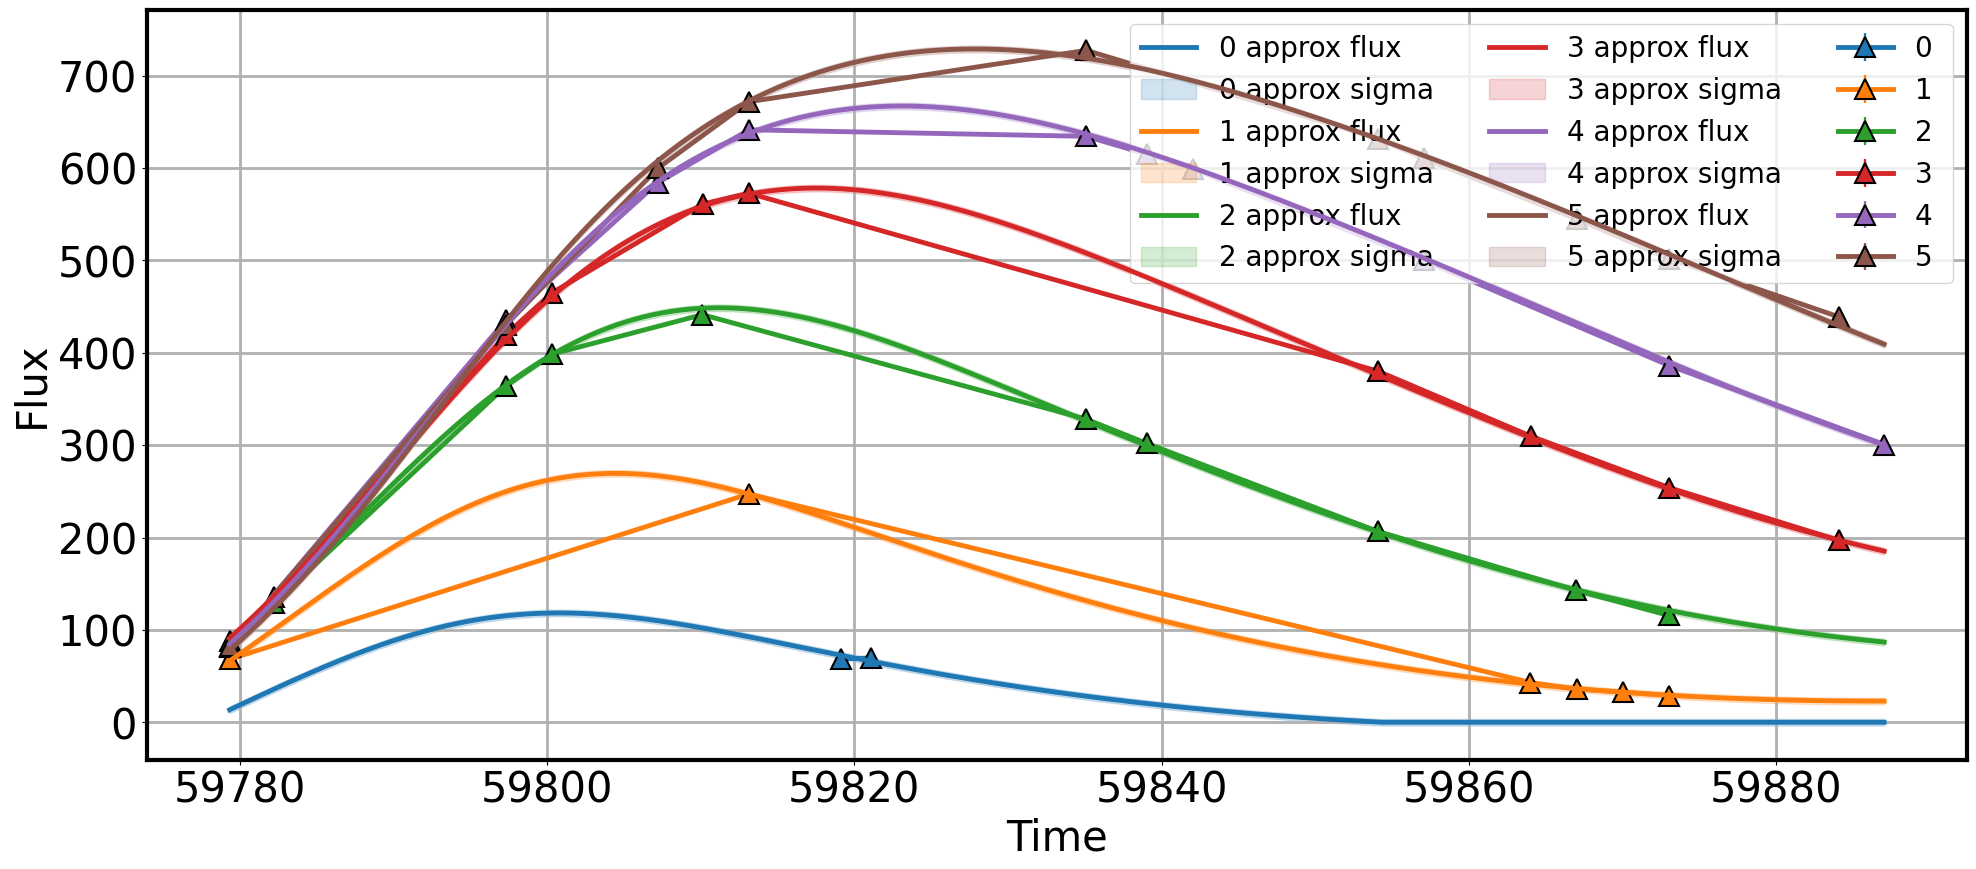

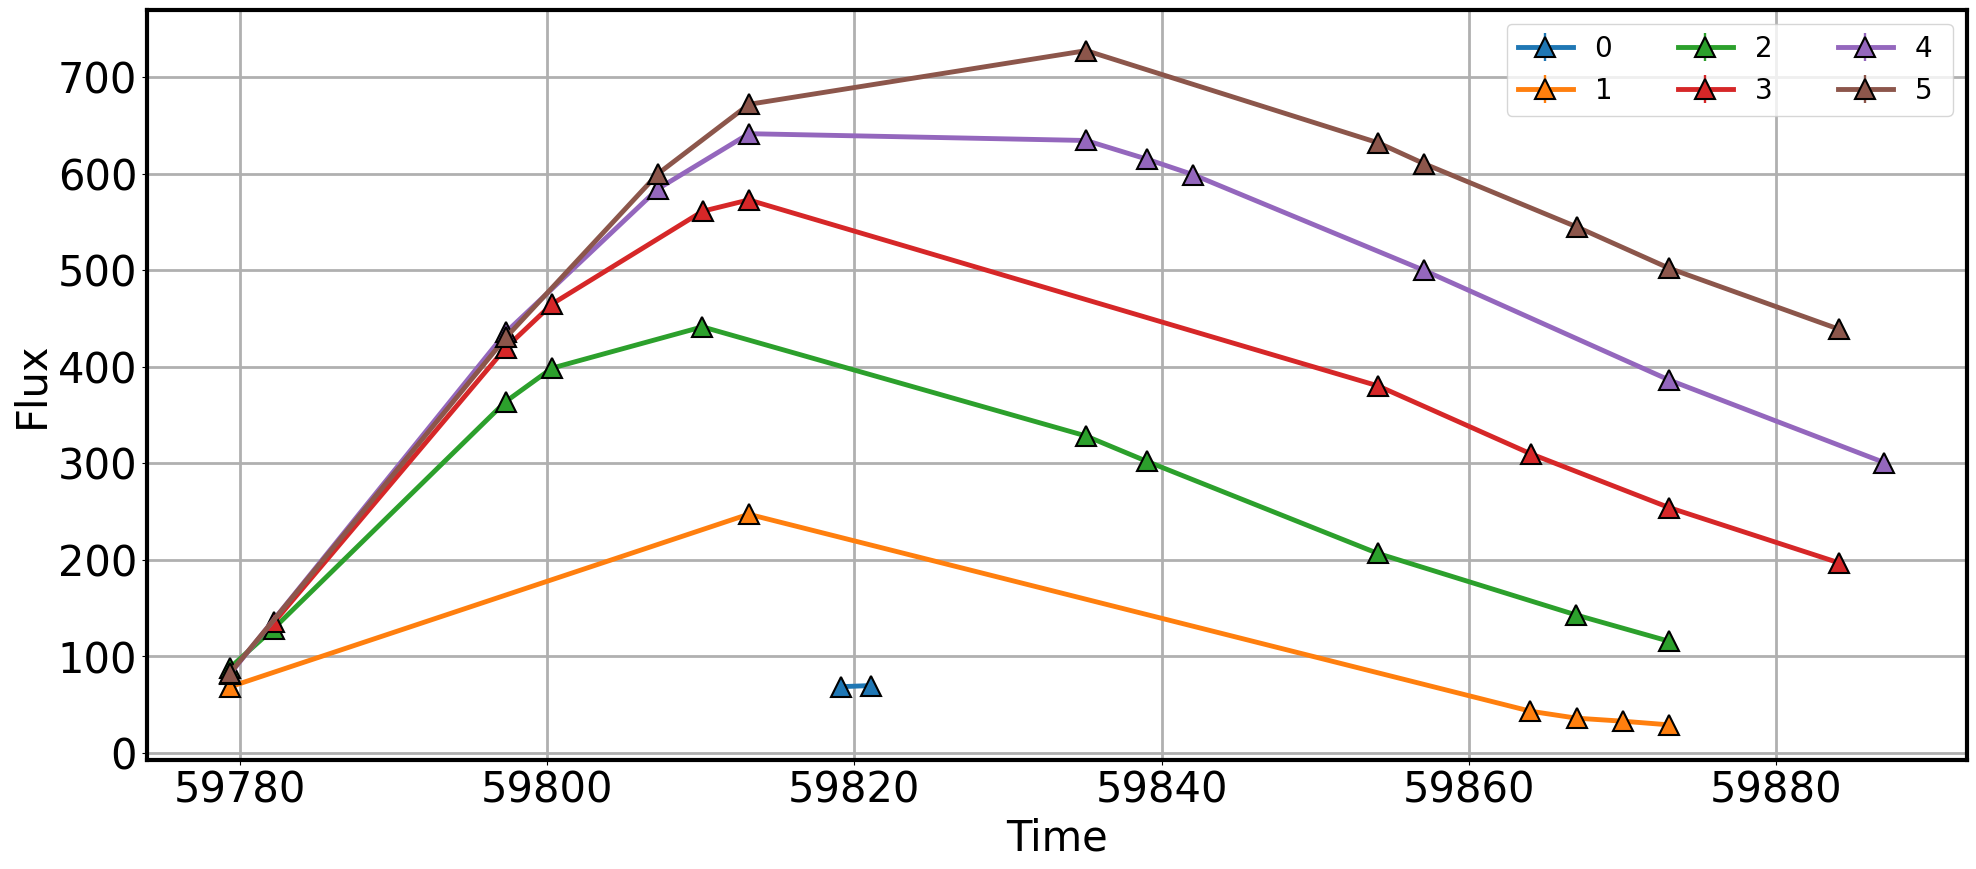

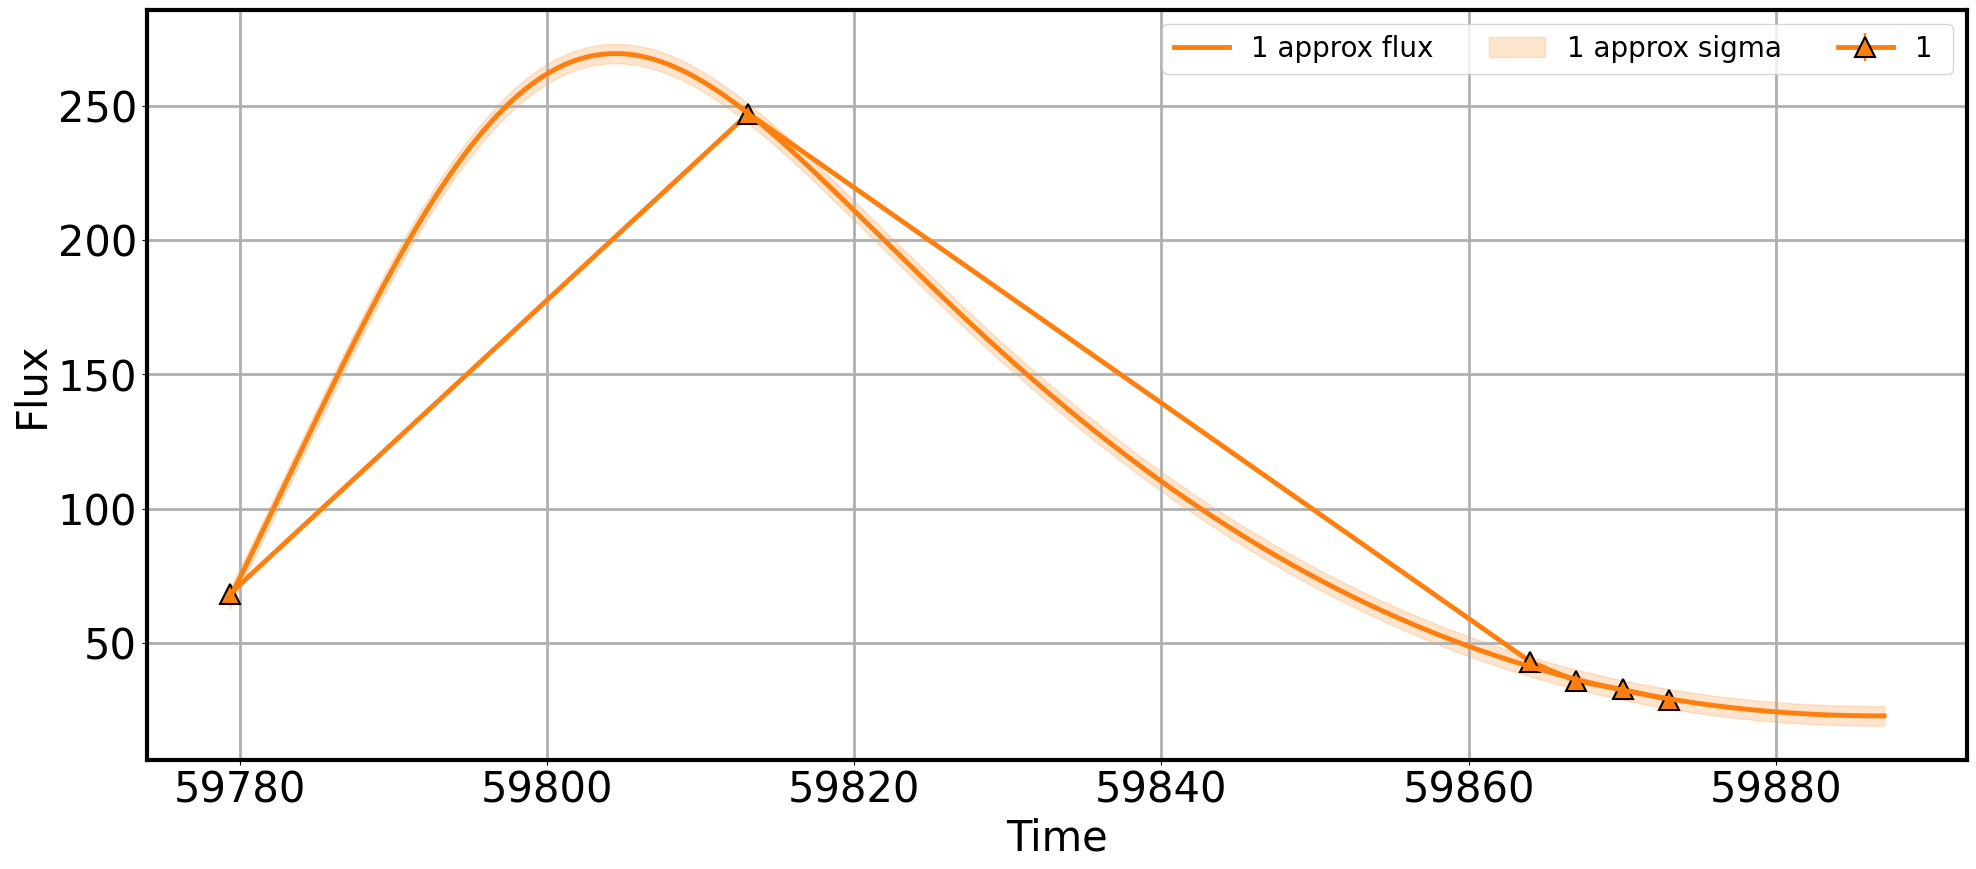

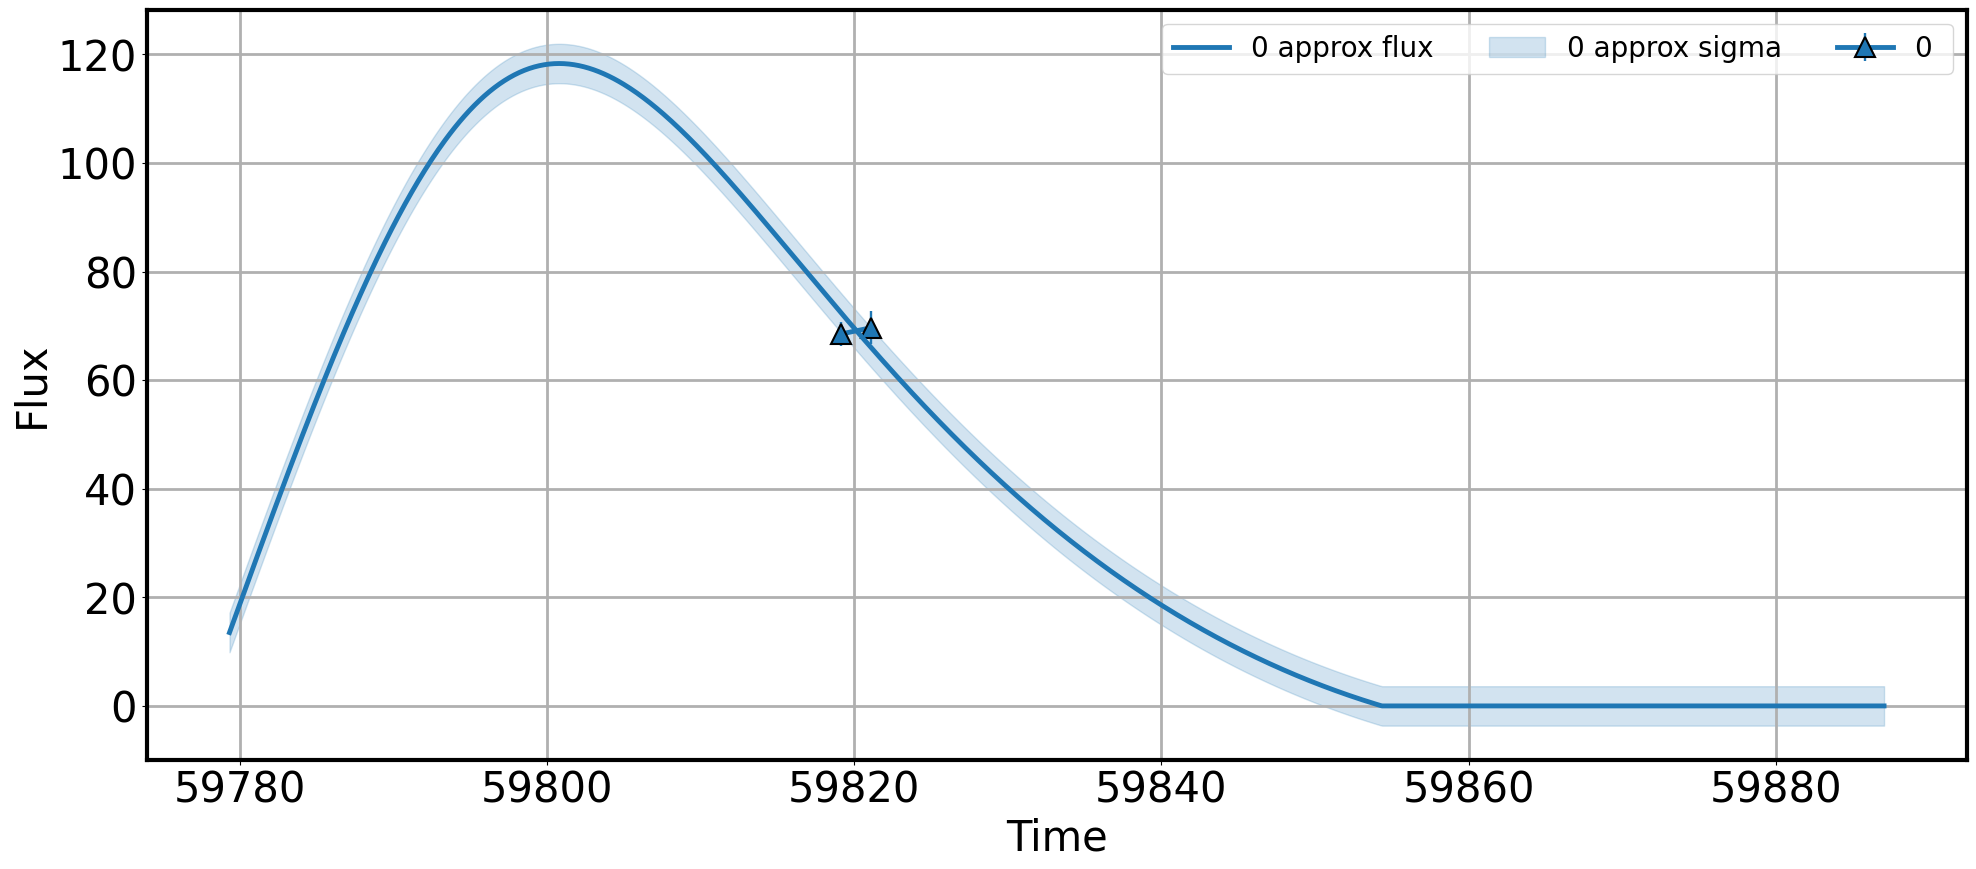

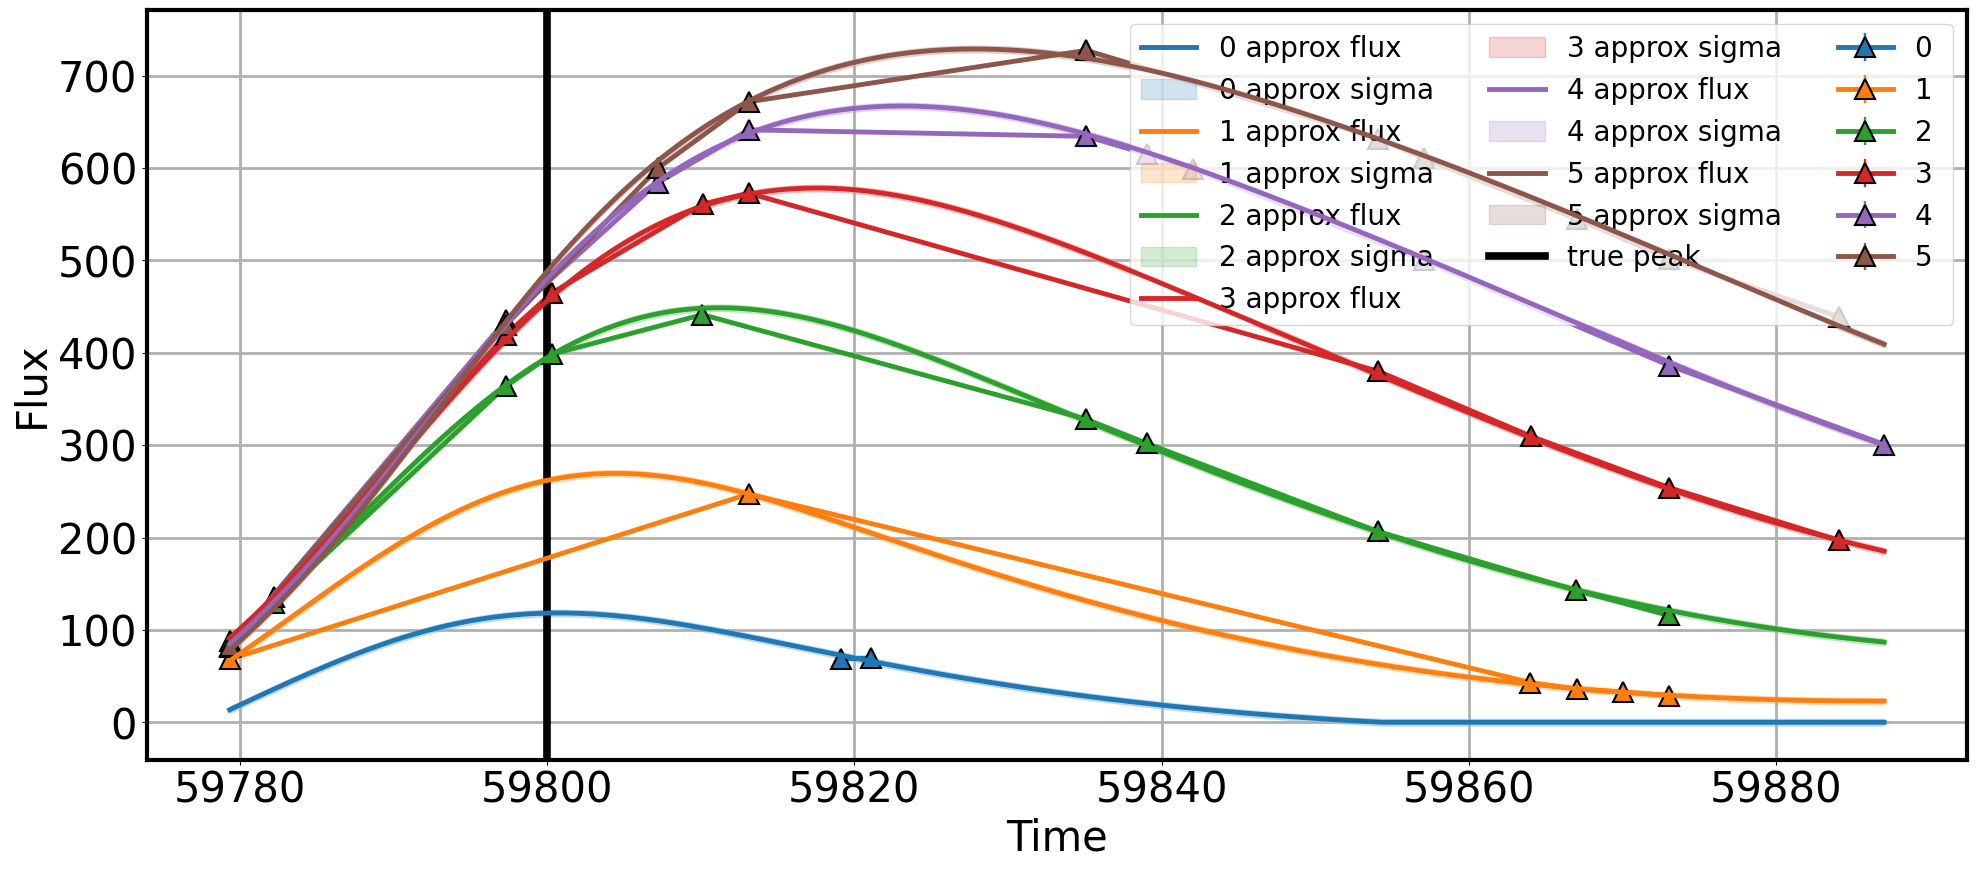

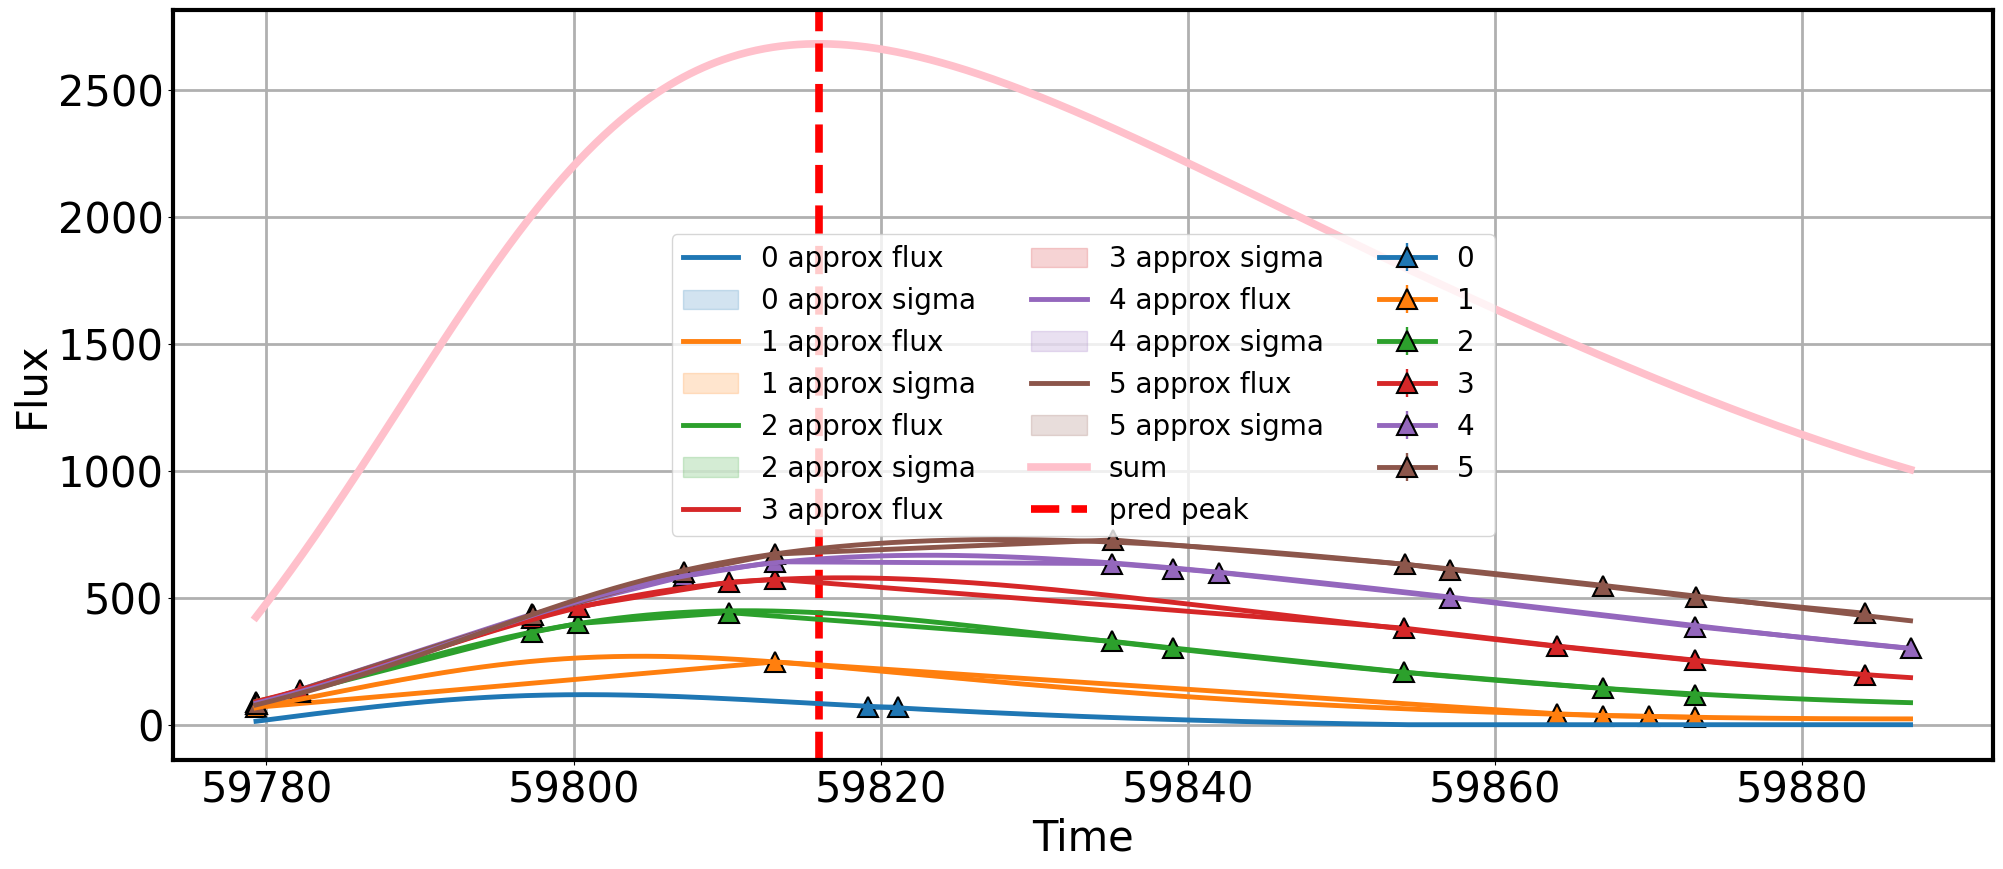

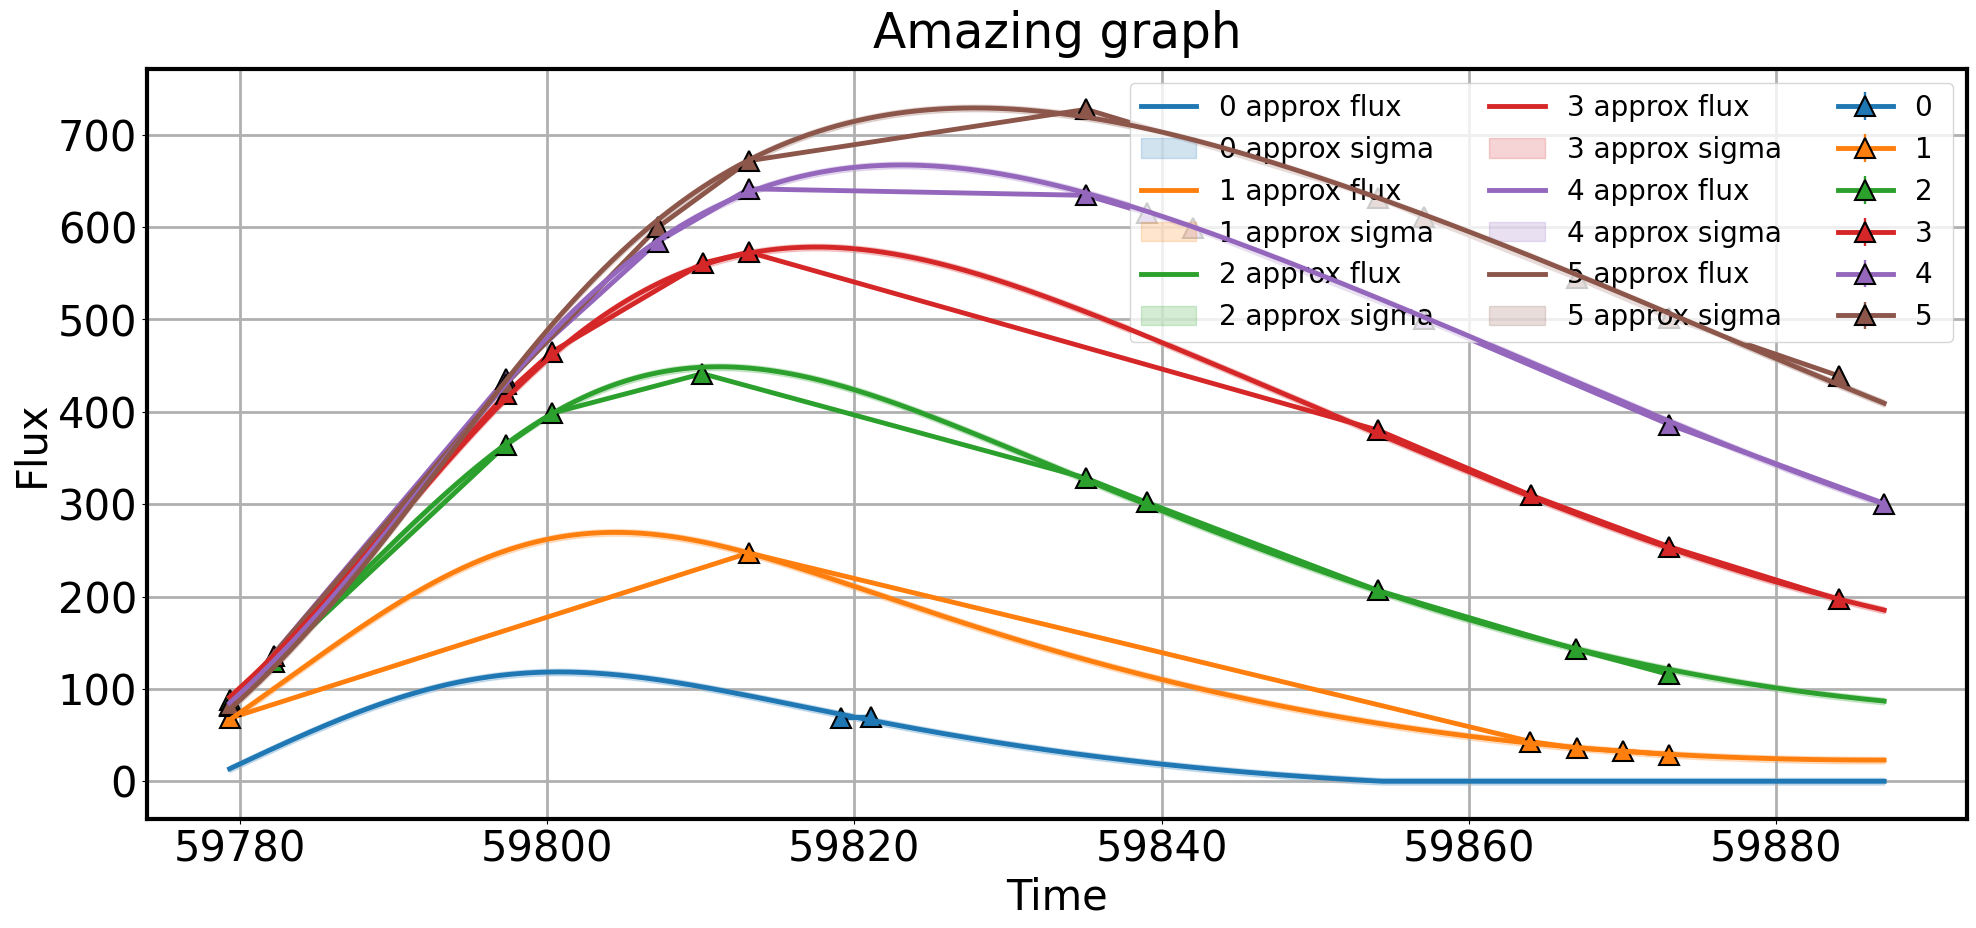

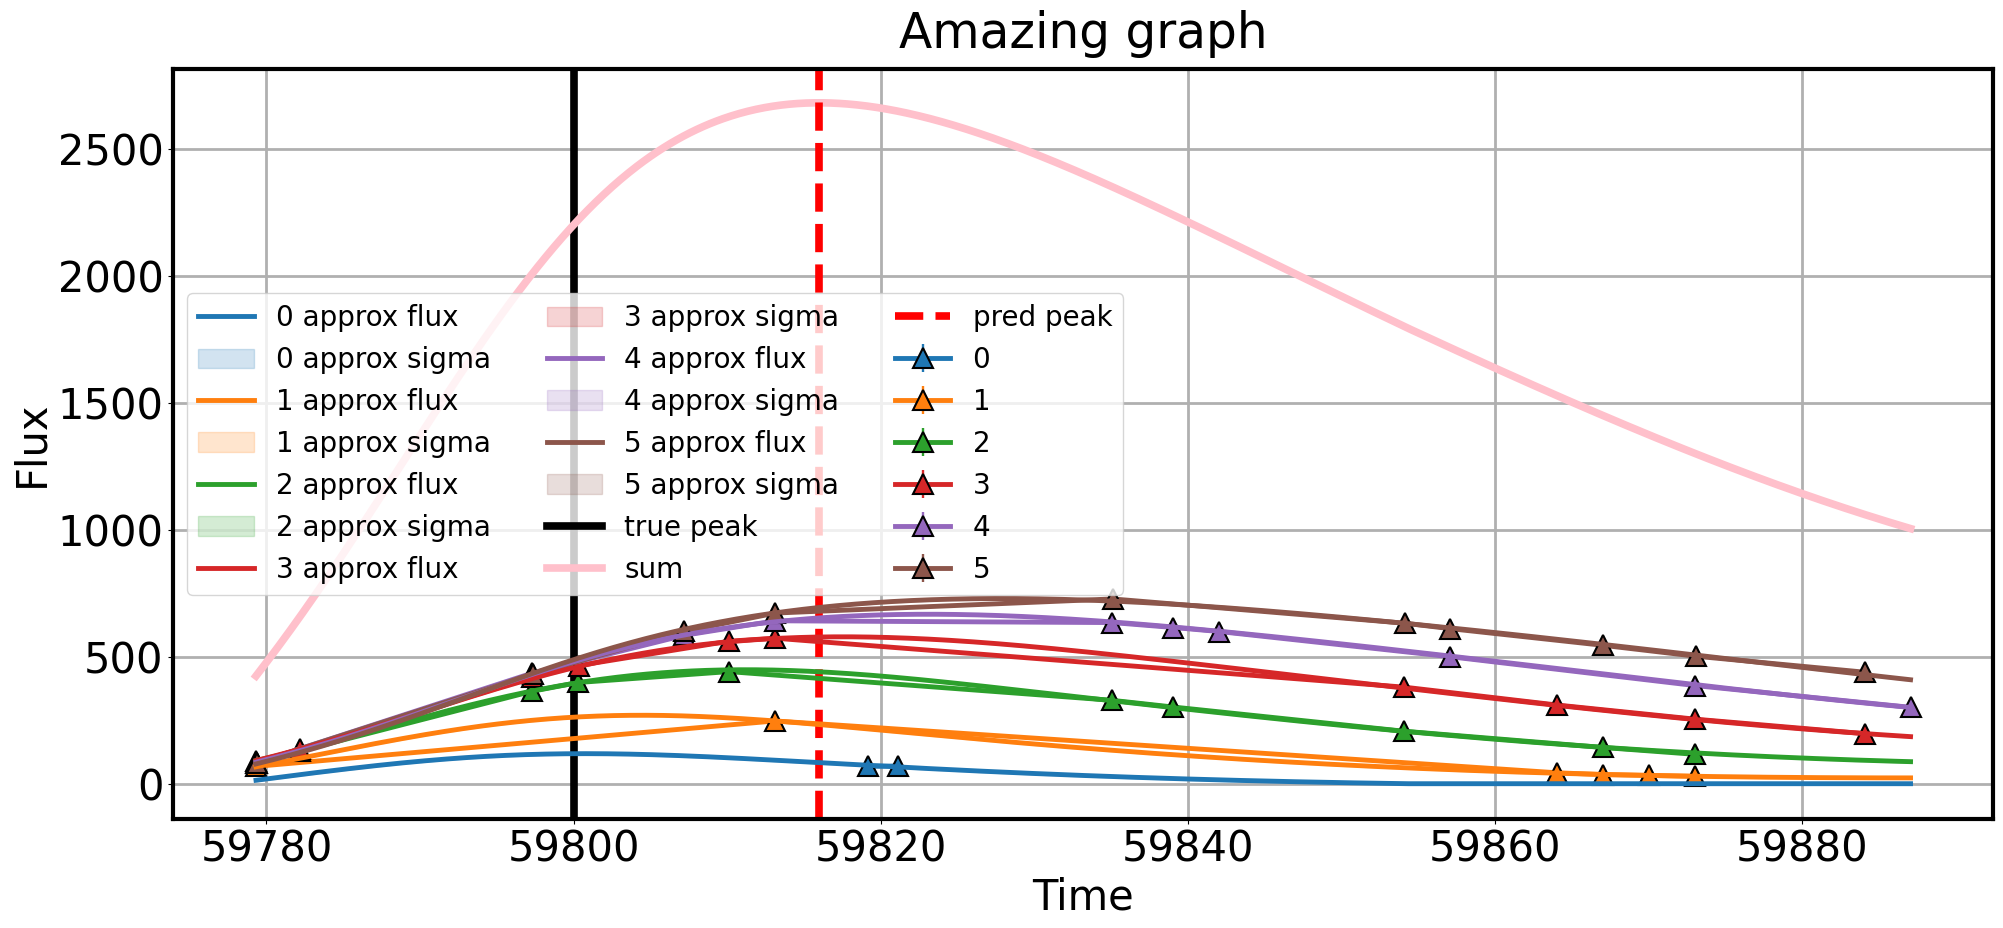

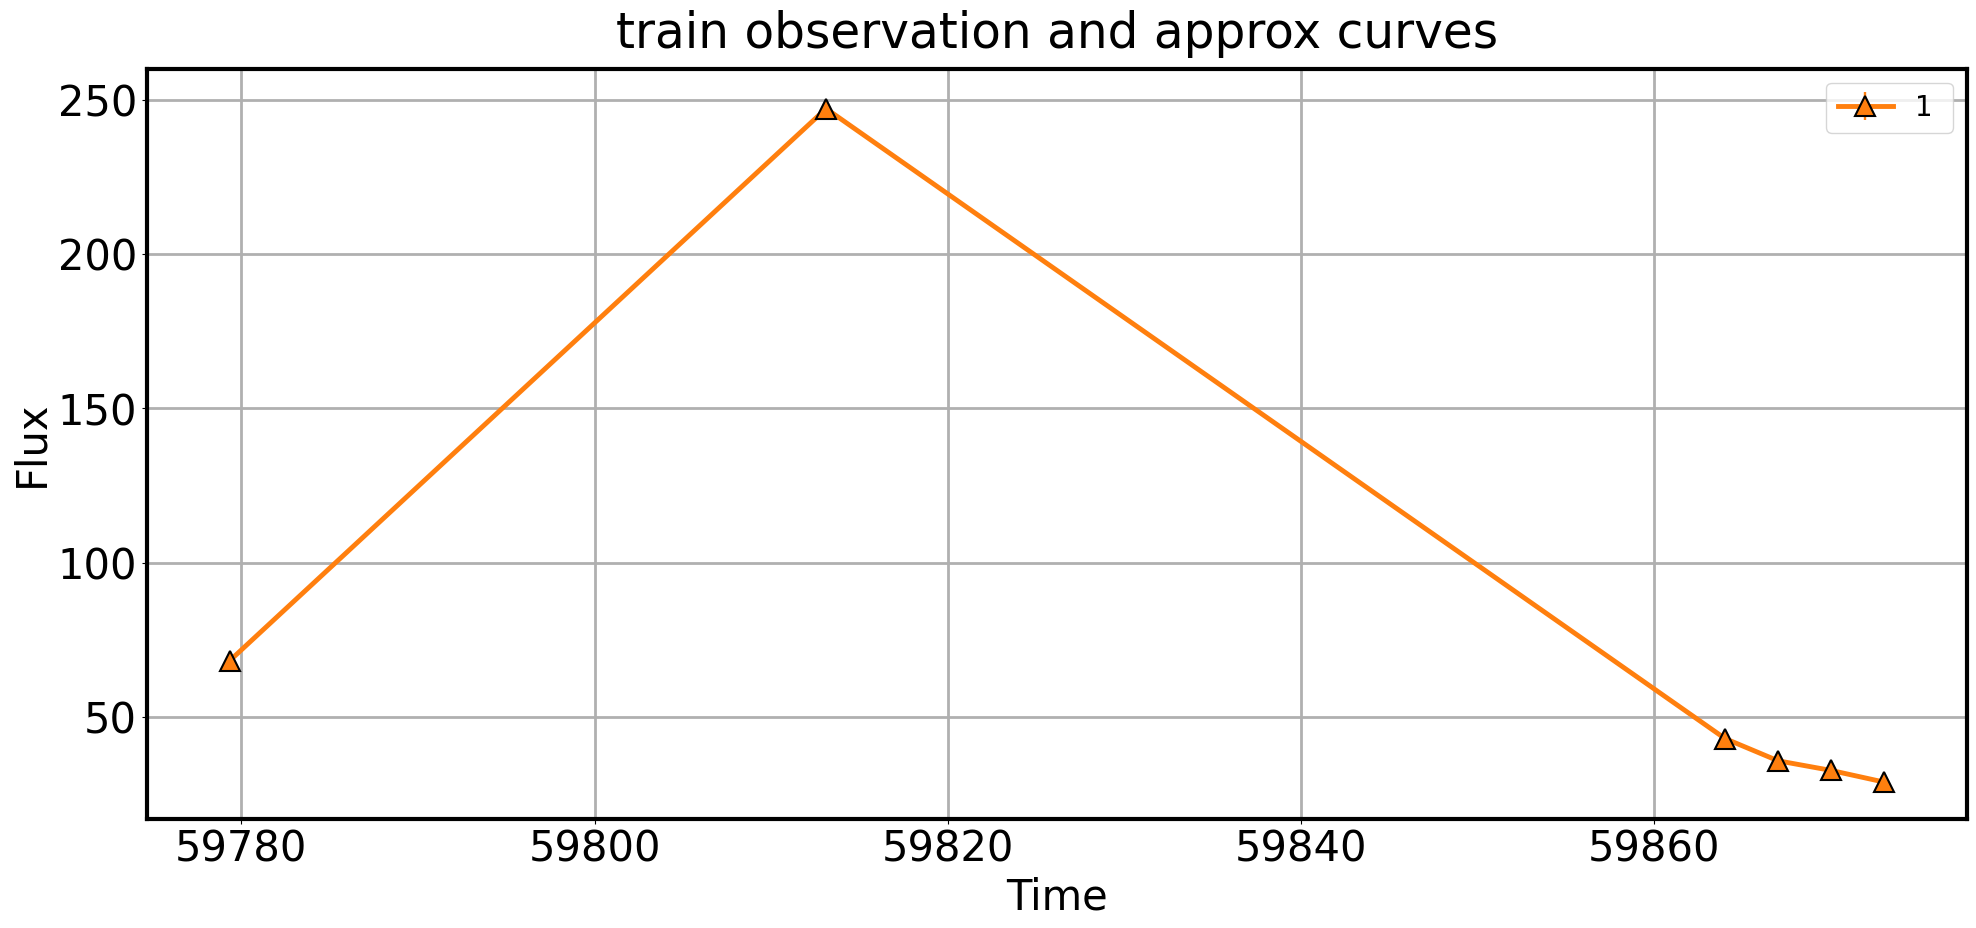

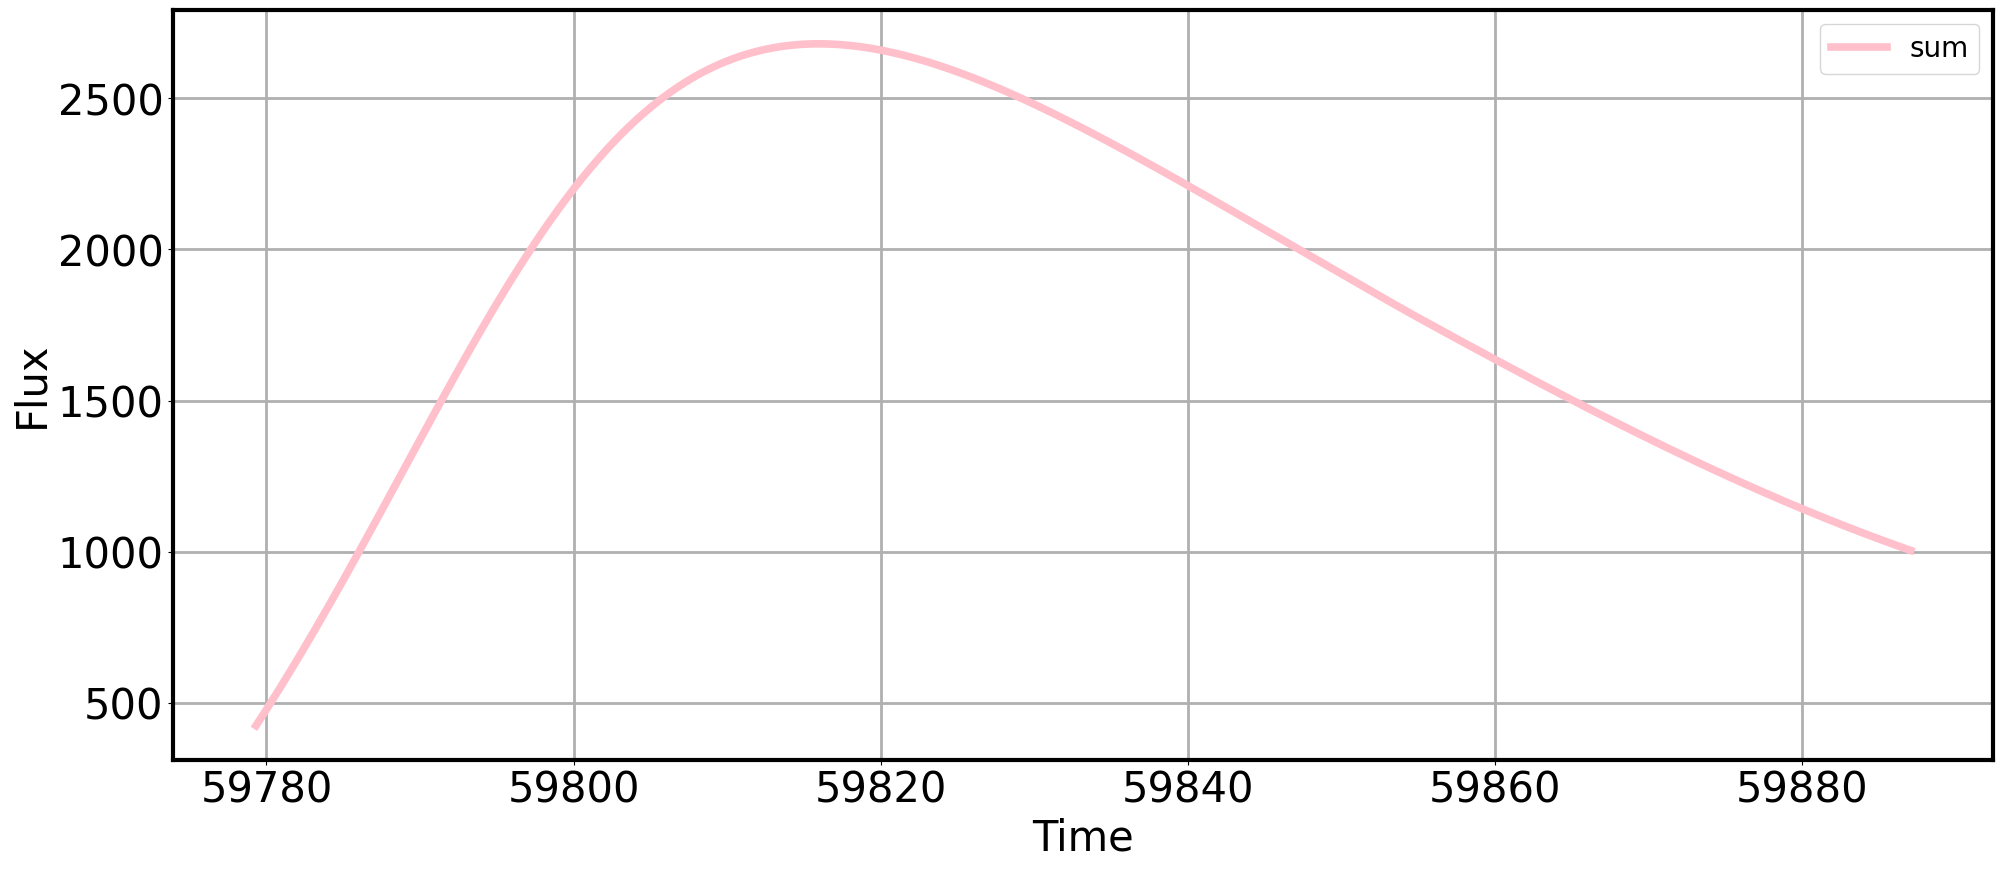

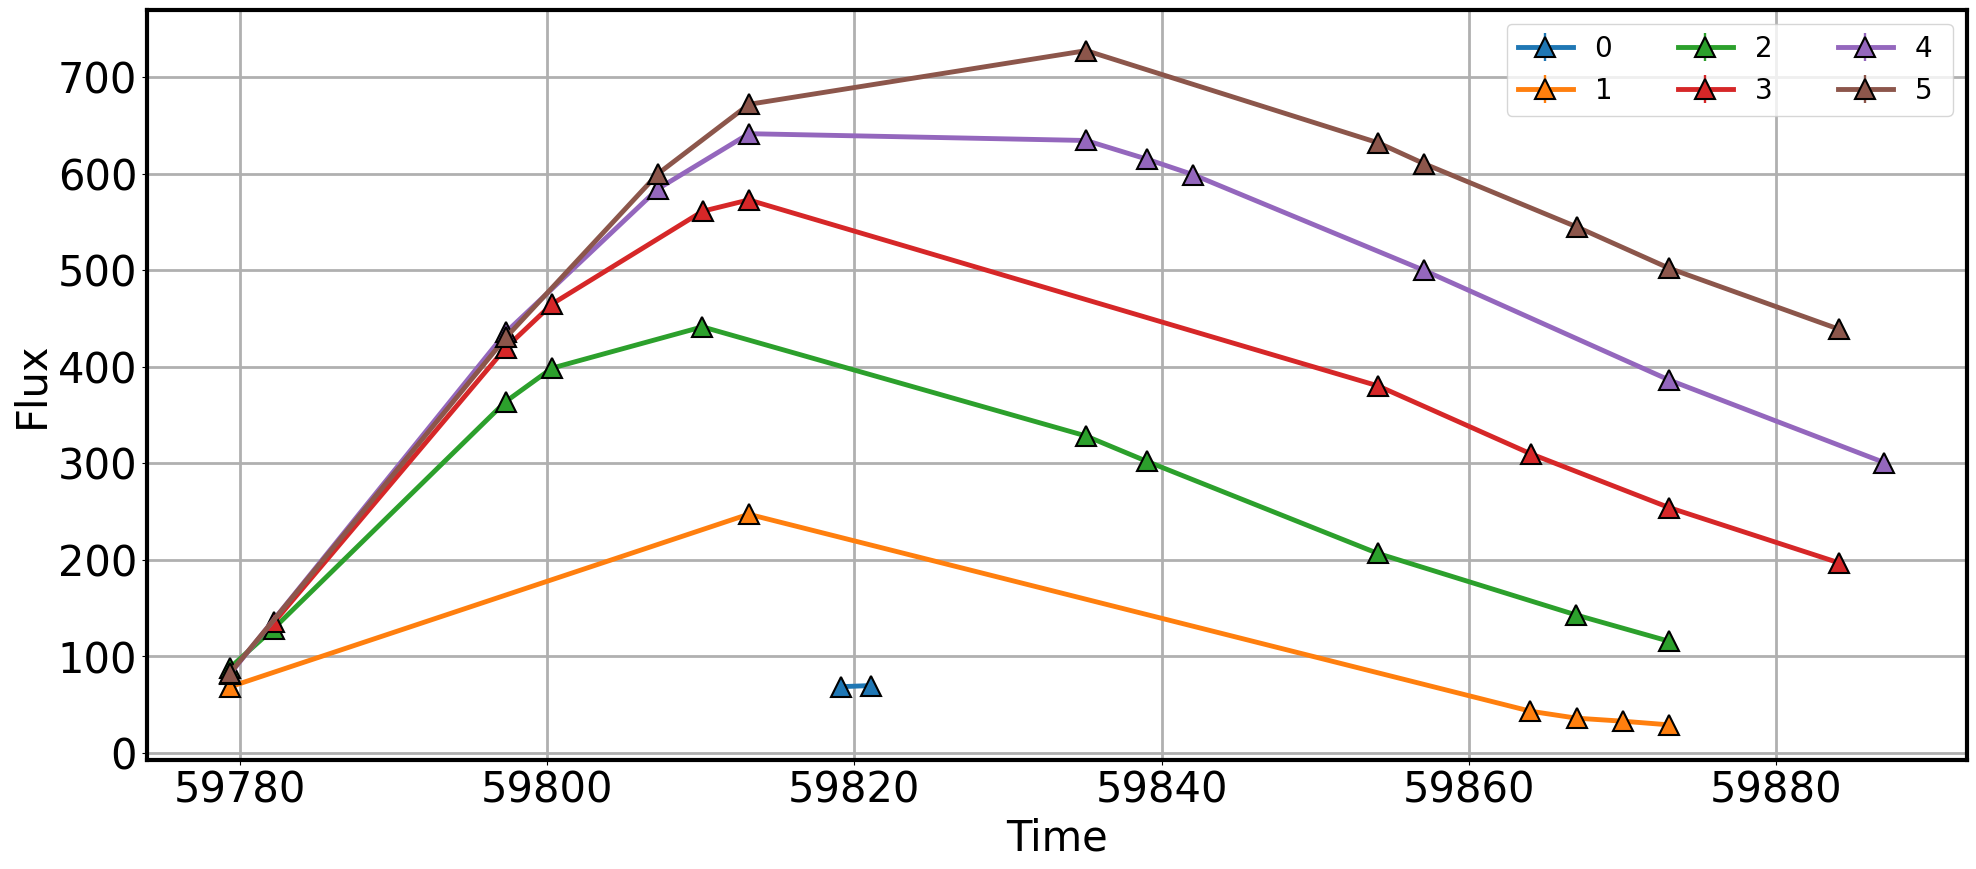

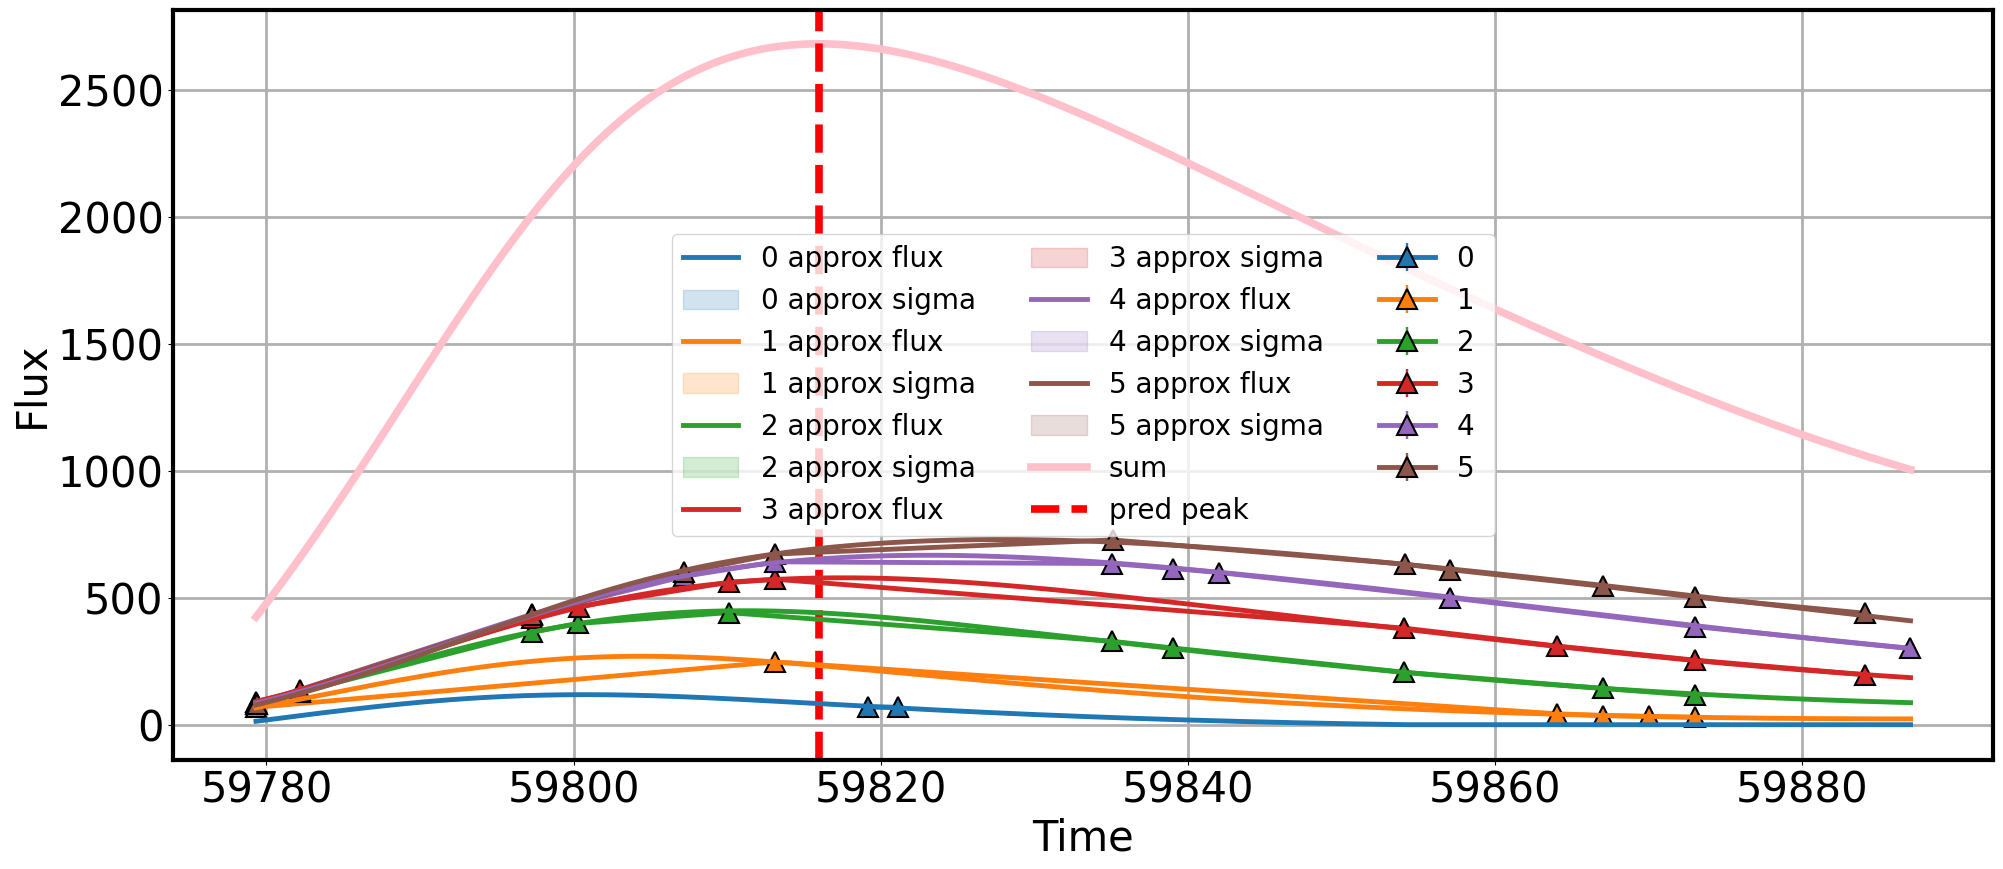

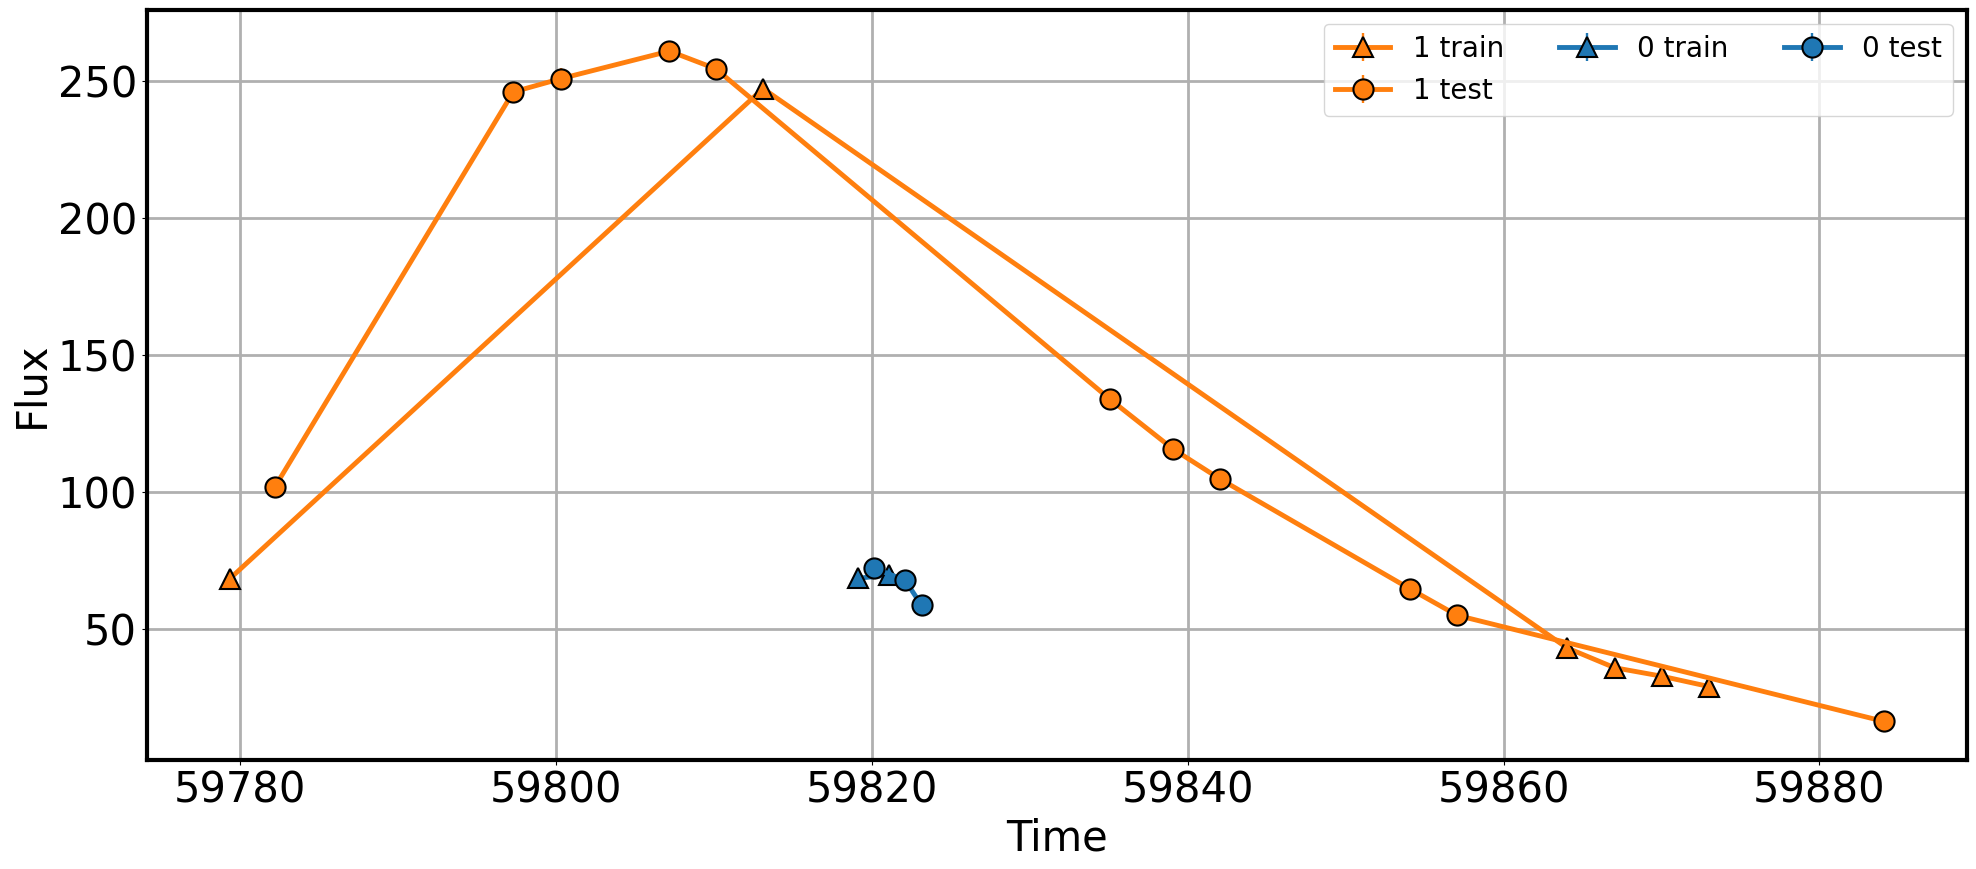

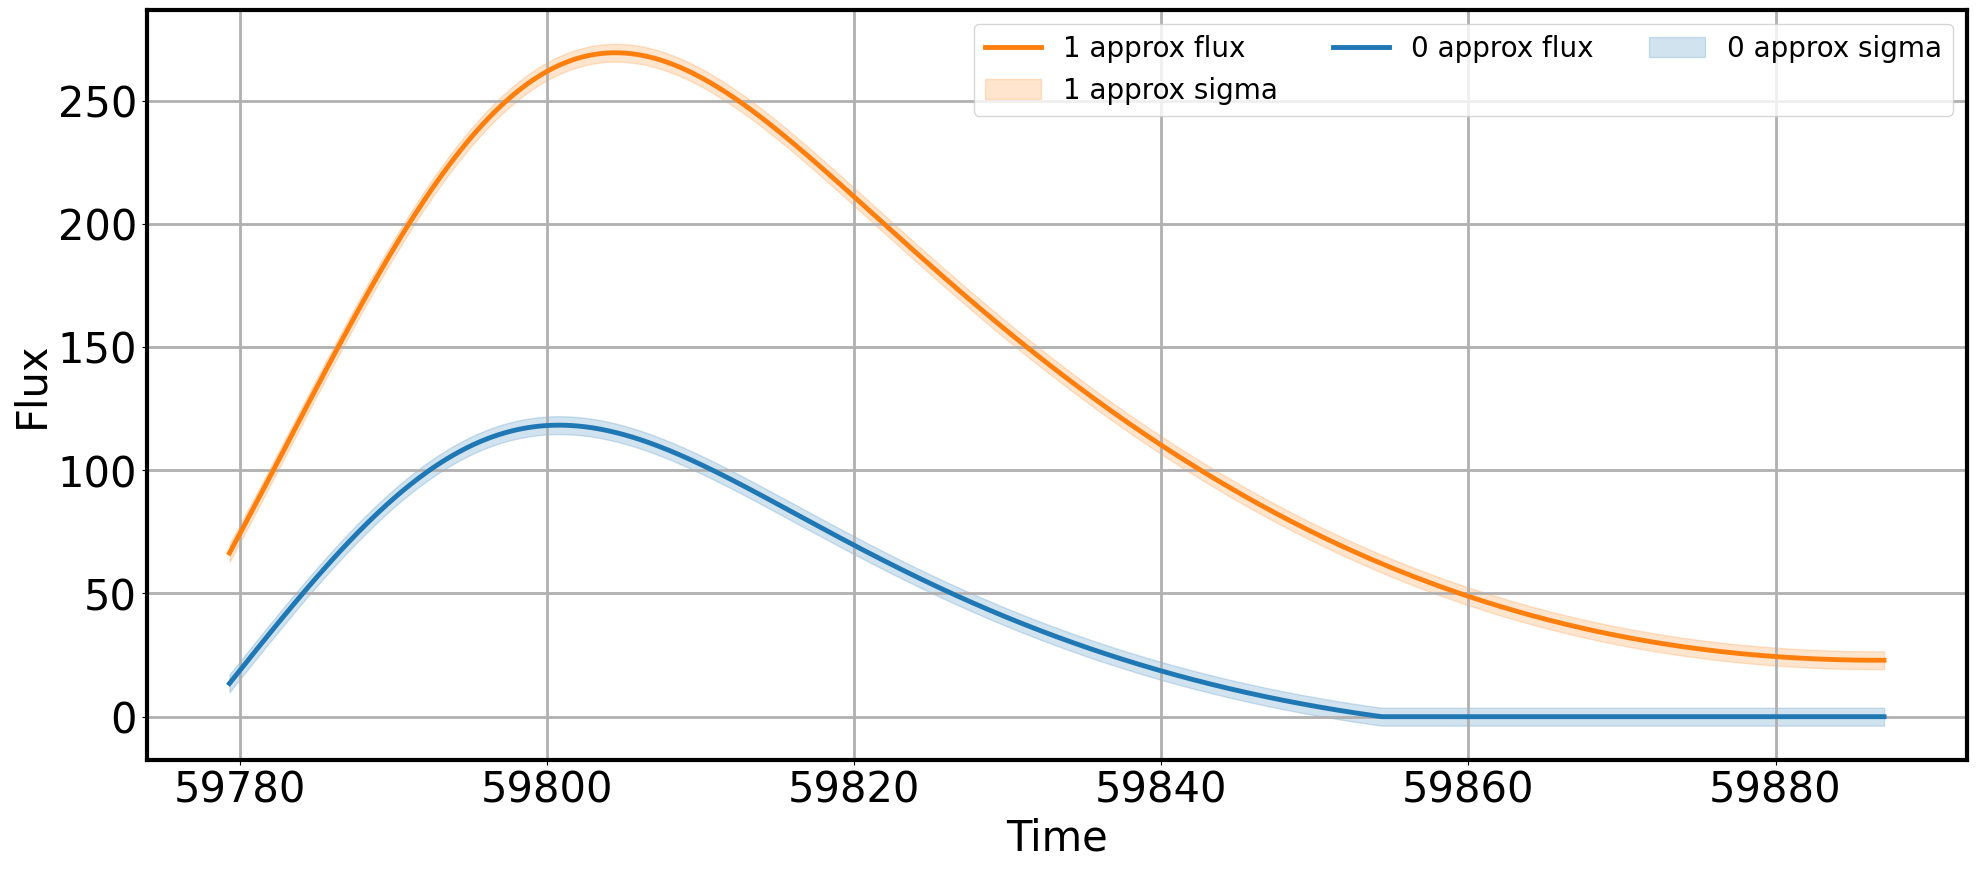

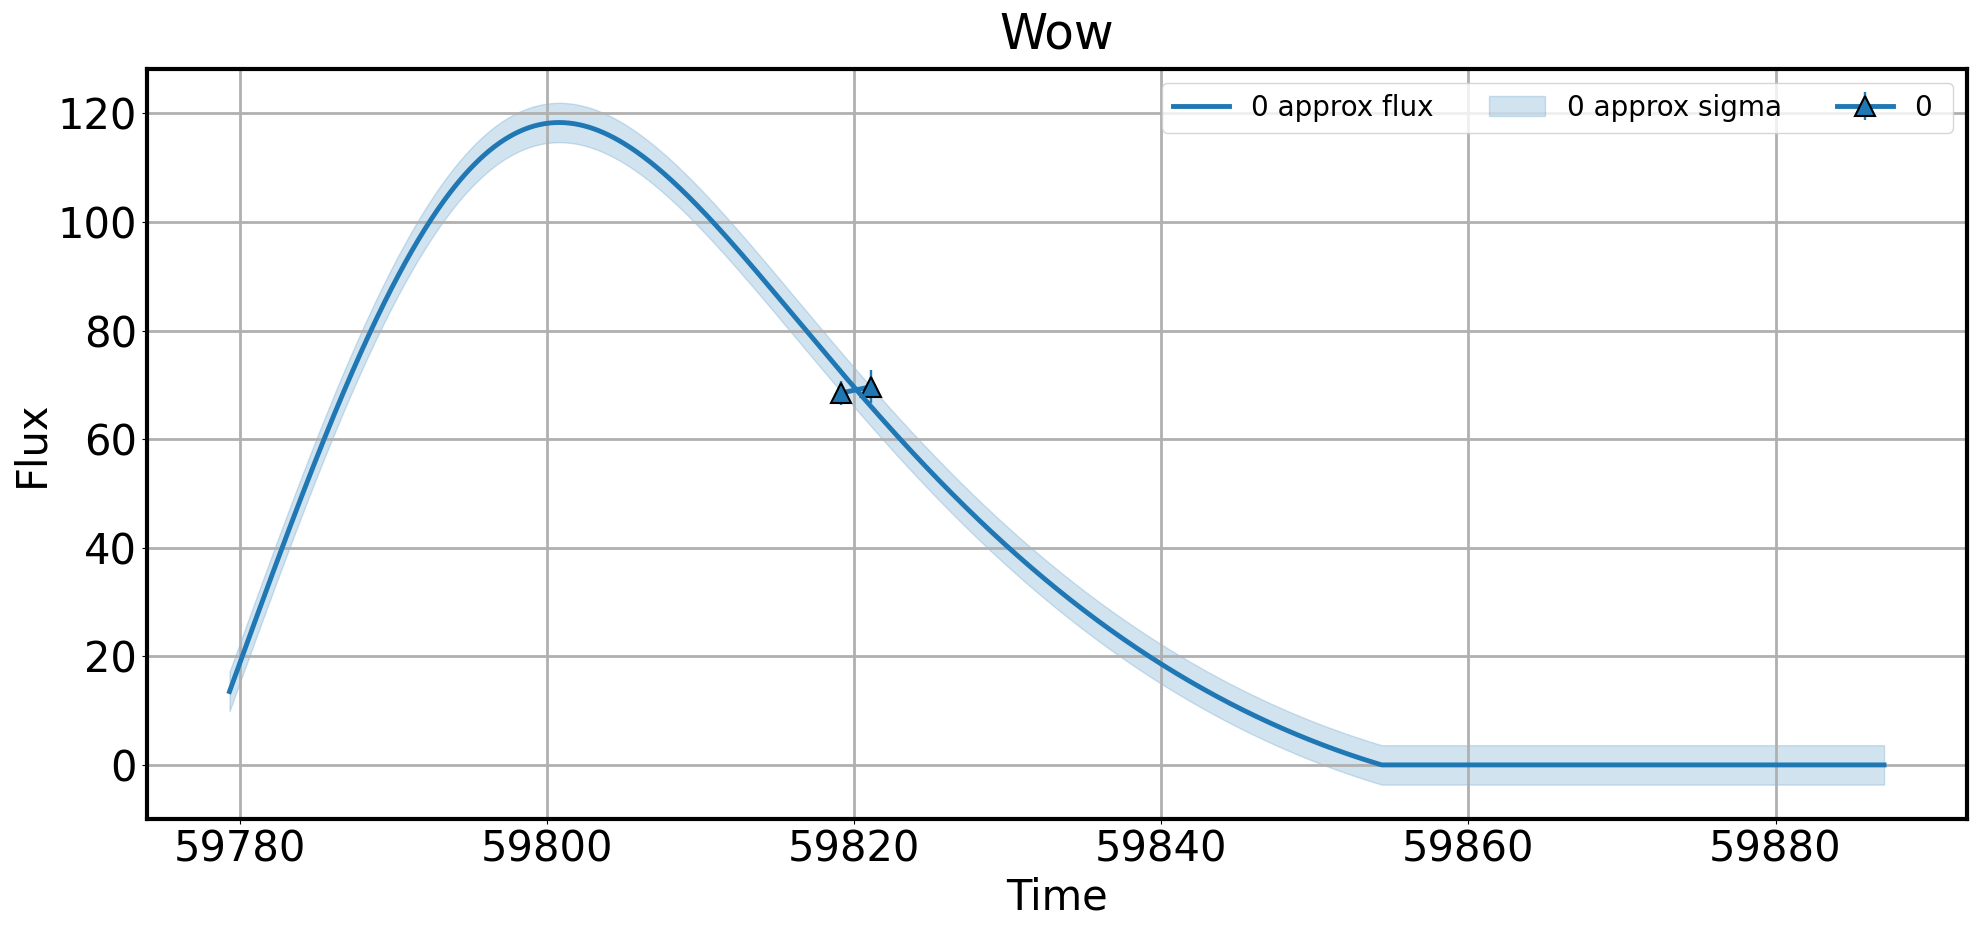

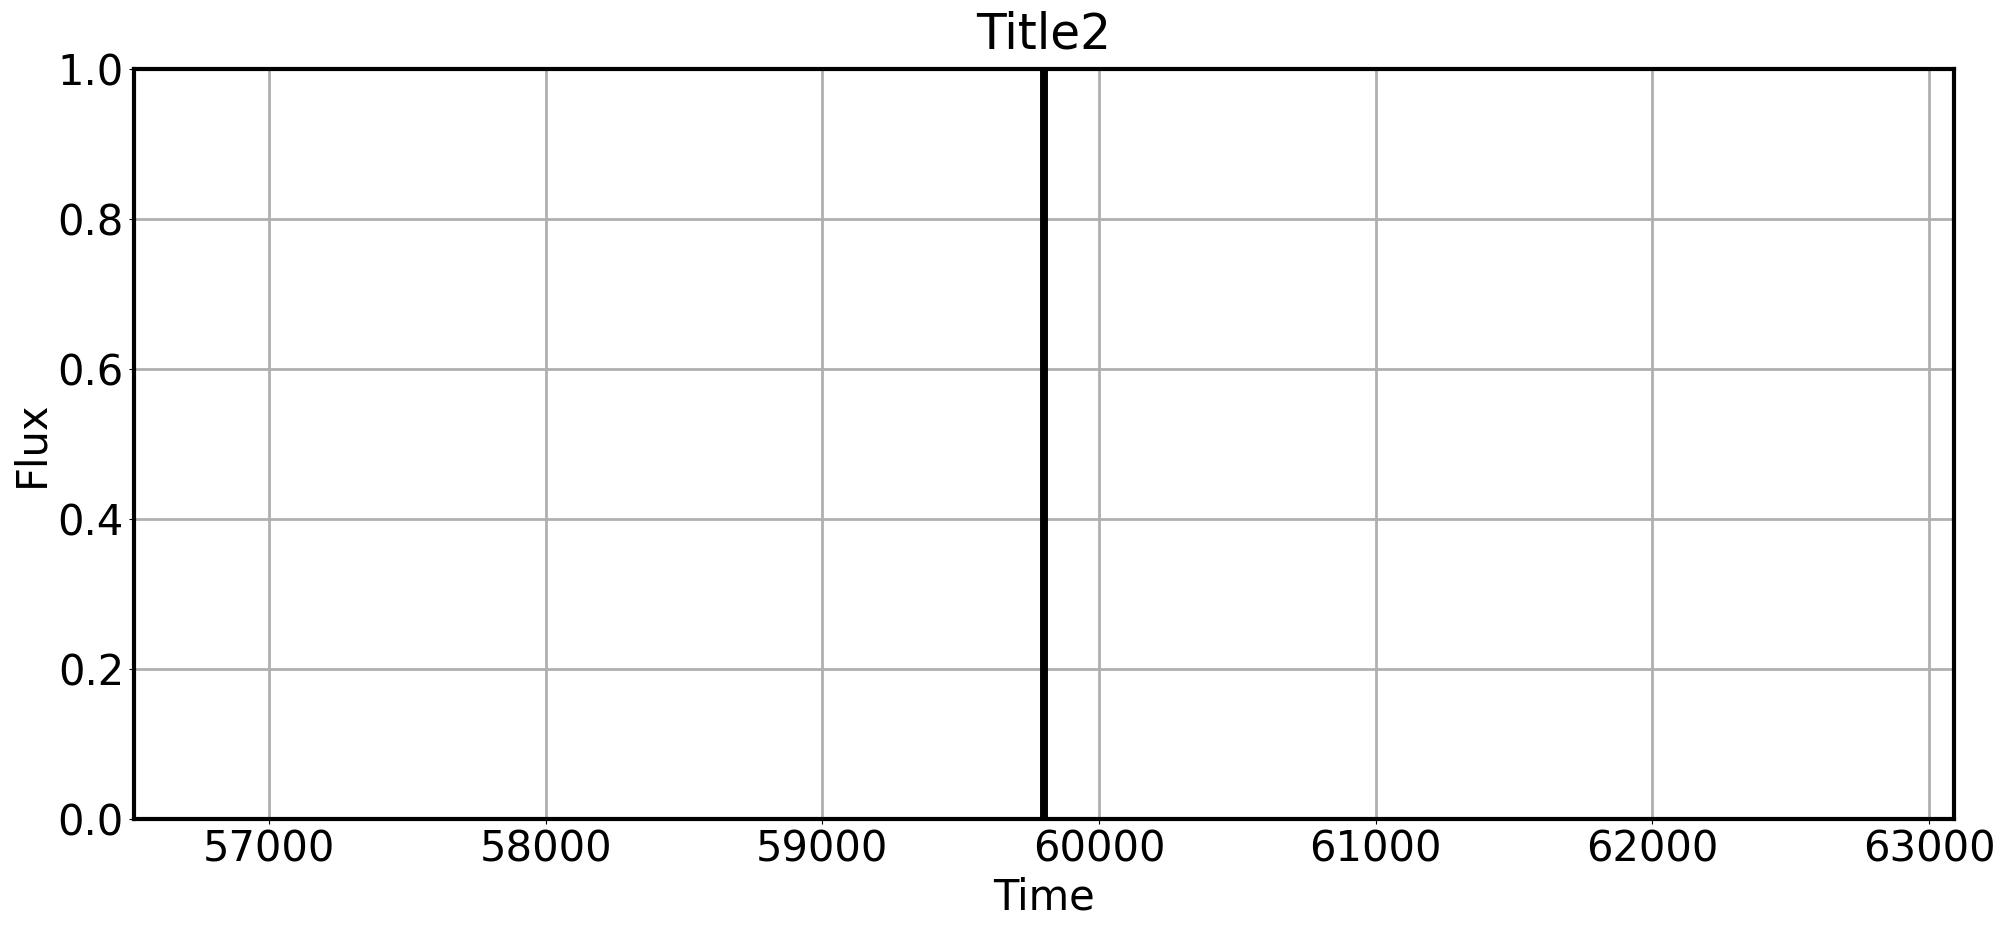

In [2]:
test('NN (sklearn)')